# Challenge: Preparing a dataset for modeling

Now it's time to play with some data. You're going to work through the stages of model preparation we've covered in this lesson and write up each one. Keep a good record in a Jupyter notebook – we'll come back to your features in a future model-building assignment on Least Squares Regression.

Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import scipy.stats as stats

In [3]:
# Making the scatterplot matrix
# Set the default plot aesthetics to be prettier.
sns.set(style="whitegrid", palette="muted")
current_palette = sns.color_palette()


df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv',na_values='NaN')

In [4]:
df.dropna(subset=['agea']).head(6)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0
6,CH,40.0,6,3.0,0.0,5.0,2.0,0.0,2.0,2.0,1.0,76.0,1.0


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


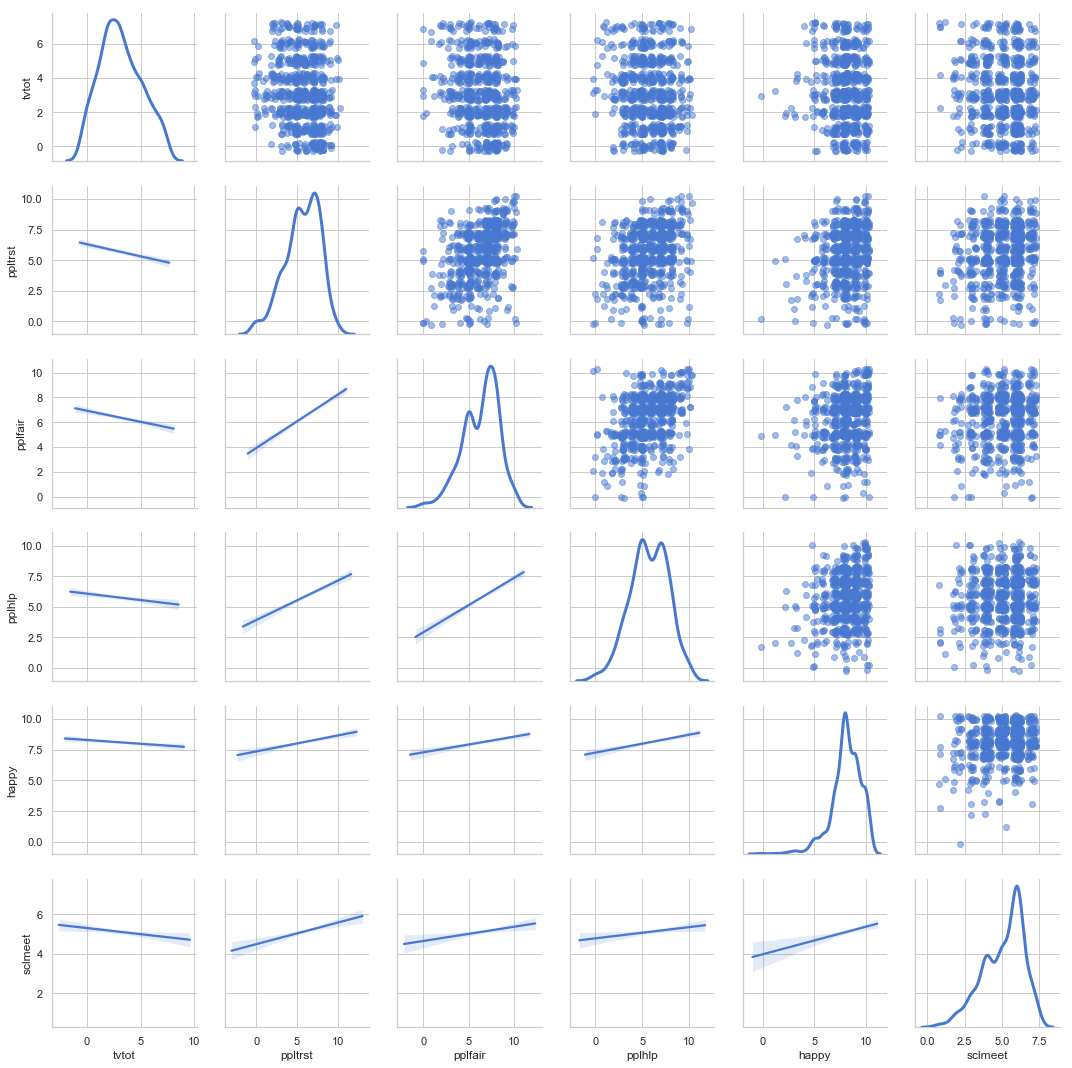

In [5]:

# Taking a subset of the data to make plots clearer.
df_czch = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year'] == 6),
    ['cntry', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet']
]

# Making a copy of the data to add jitter to and plot.
df_jittered = df_czch.loc[:, 'tvtot':'sclmeet'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)

# Scatterplot.data.isnull().any()
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

            tvtot   ppltrst   pplfair    pplhlp     happy   sclmeet
tvtot    1.000000 -0.240432 -0.233280 -0.176517 -0.265293 -0.144105
ppltrst -0.240432  1.000000  0.605589  0.500378  0.297432  0.148949
pplfair -0.233280  0.605589  1.000000  0.532927  0.275204  0.105886
pplhlp  -0.176517  0.500378  0.532927  1.000000  0.269627  0.109383
happy   -0.265293  0.297432  0.275204  0.269627  1.000000  0.244289
sclmeet -0.144105  0.148949  0.105886  0.109383  0.244289  1.000000


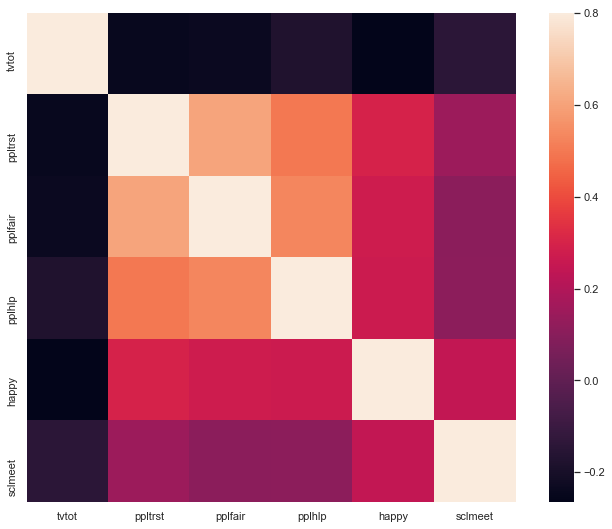

In [6]:
# Making the correlation matrix.
corrmat = df_czch.corr()
print(corrmat)

# Seting up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Drawing the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


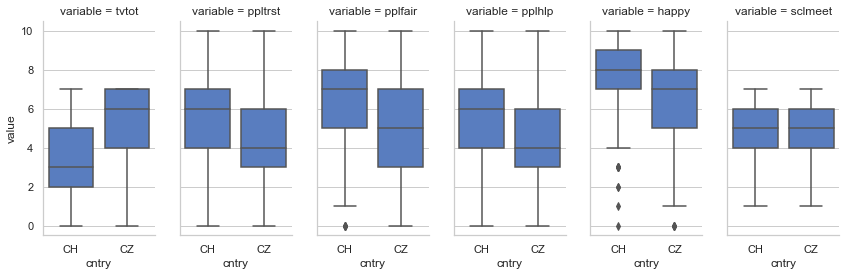

       happy                                               pplfair            \
       count      mean       std  min  25%  50%  75%   max   count      mean   
cntry                                                                          
CH     770.0  8.088312  1.437920  0.0  7.0  8.0  9.0  10.0   770.0  6.350649   
CZ     646.0  6.770898  2.053582  0.0  5.0  7.0  8.0  10.0   649.0  4.959938   

      ...  sclmeet       tvtot                                               
      ...      75%  max  count      mean       std  min  25%  50%  75%  max  
cntry ...                                                                    
CH    ...      6.0  7.0  772.0  3.141192  1.913706  0.0  2.0  3.0  5.0  7.0  
CZ    ...      6.0  7.0  653.0  5.142420  1.851775  0.0  4.0  6.0  7.0  7.0  

[2 rows x 48 columns]
tvtot
Ttest_indResult(statistic=19.962218108197227, pvalue=2.321576398582079e-78)
ppltrst
Ttest_indResult(statistic=-10.928900558029875, pvalue=9.394029017549828e-27)
pplfair
Ttest_indRe

In [7]:

# Plot all the variables with boxplots for each country.

# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.
df_long = df_czch

# pd.melt transposes the data so that cntry is now on the x-axis
df_long = pd.melt(df_long, id_vars=['cntry'])

g = sns.FacetGrid(df_long, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "cntry", "value")
plt.show()

# Descriptive statistics by group.
print(df_czch.groupby('cntry').describe())

# T-Test whether group differences are significant.
for col in df_czch.loc[:,'tvtot':'sclmeet'].columns:
    print(col)
    print(stats.ttest_ind(
        df_czch[df_czch['cntry'] == 'CZ'][col].dropna(),
        df_czch[df_czch['cntry'] == 'CH'][col].dropna()
    ))

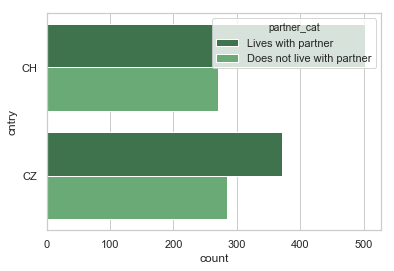

partner_cat  Does not live with partner  Lives with partner
cntry                                                      
CH                                  270                 503
CZ                                  284                 372
Power_divergenceResult(statistic=96.39958012596222, pvalue=9.236593586645439e-21)


In [8]:
# Add a second categorical variable.
df_2cat = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year'] == 6),
    ['cntry','partner']
]

# Create a text variable so that output is easier to interpret.
df_2cat['partner_cat'] = None
df_2cat.loc[df_2cat['partner'] == 1, 'partner_cat'] = 'Lives with partner'
df_2cat.loc[df_2cat['partner'] == 2, 'partner_cat'] = 'Does not live with partner'

# Plot counts for each combination of levels.
sns.countplot(y="cntry", hue="partner_cat", data=df_2cat, palette="Greens_d")
plt.show()

# Table of counts
counttable = pd.crosstab(df_2cat['cntry'], df_2cat['partner_cat'])
print(counttable)

# Test will return a chi-square test statistic and a p-value. Like the t-test,
# the chi-square is compared against a distribution (the chi-square
# distribution) to determine whether the group size differences are large
# enough to reflect differences in the population.
print(stats.chisquare(counttable, axis=None))

In [9]:
# Take a subset of the data to make plots clearer.
print(df.head())
print(df.cntry.unique())

  cntry  idno  year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  \
0    CH   5.0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   
1    CH  25.0     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   
2    CH  26.0     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   
3    CH  28.0     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   
4    CH  29.0     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   

   gndr  agea  partner  
0   2.0  60.0      1.0  
1   2.0  59.0      1.0  
2   1.0  24.0      2.0  
3   2.0  64.0      1.0  
4   2.0  55.0      1.0  
['CH' 'CZ' 'DE' 'ES' 'NO' 'SE']


In [10]:
# Making dummies.
# Also creating a data frame to hold our features.
features = pd.get_dummies(df['cntry'])

# Landlocked countries dummy.
features['Landlocked'] = np.where((df['cntry'].isin(['CZ'])), 1, 0)

print(pd.crosstab(features['Landlocked'], df['cntry']))

cntry         CH    CZ  DE    ES    NO    SE
Landlocked                                  
0           1546     0  28  2426  1462  1816
1              0  1316   0     0     0     0


In [11]:
features['Adult_25under'] = np.where(df['agea']<=25, 1, 0)

# Check to make sure it worked.
print(df['agea'].groupby(features['Adult_25under']).describe())

                count       mean        std   min   25%   50%   75%    max
Adult_25under                                                             
0              7078.0  52.374258  15.512941  26.0  40.0  51.0  64.0  114.0
1              1277.0  20.292091   2.929695  15.0  18.0  20.0  23.0   25.0


In [12]:
correlated = df[['ppltrst','pplfair','pplhlp']]
correlated.dropna()
correlated.head()

,ppltrst,pplfair,pplhlp
0,3.0,10.0,5.0
1,5.0,7.0,5.0
2,8.0,8.0,8.0
3,6.0,6.0,7.0
4,6.0,7.0,5.0


In [13]:
correlated['ppltrstlog'] = np.log(1 + correlated.ppltrst)
correlated['pplfairlog'] = np.log(1 + correlated.pplfair)
correlated['pplhlplog'] = np.log(1 + correlated.pplhlp)
correlated['ppltrstsq'] = correlated['ppltrst']**2
correlated['pplfairsq'] = correlated['pplfair']**2
correlated['pplhlpsq'] = correlated['pplhlp']**2
correlated['pplintsum'] = correlated['ppltrst'] + correlated['pplfair'] + correlated['pplhlp']

# Looks like 'pplfair','ppltrst' and 'pplhlp' are pretty redundant with each
# other. Let's make some averages. Just in case some of the variables are on
# different scales than others (one ranges from 0 to 100, one ranges from 0 to
# 7, for example) we scale them before averaging by subtracting the average of
# each variable from all values in that variable, then dividing by the
# standard deviation.
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
correlated['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)
correlated['landlocked'] = features['Landlocked']


correlated.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

,ppltrst,pplfair,pplhlp,ppltrstlog,pplfairlog,pplhlplog,ppltrstsq,pplfairsq,pplhlpsq,pplintsum,trust_fair_help,landlocked
0,3.0,10.0,5.0,1.386294,2.397895,1.791759,9.0,100.0,25.0,18.0,0.194142,0
1,5.0,7.0,5.0,1.791759,2.079442,1.791759,25.0,49.0,25.0,17.0,0.023087,0
2,8.0,8.0,8.0,2.197225,2.197225,2.197225,64.0,64.0,64.0,24.0,1.087377,0
3,6.0,6.0,7.0,1.945910,1.945910,2.079442,36.0,36.0,49.0,19.0,0.322544,0
4,6.0,7.0,5.0,1.945910,2.079442,1.791759,36.0,49.0,25.0,18.0,0.172316,0


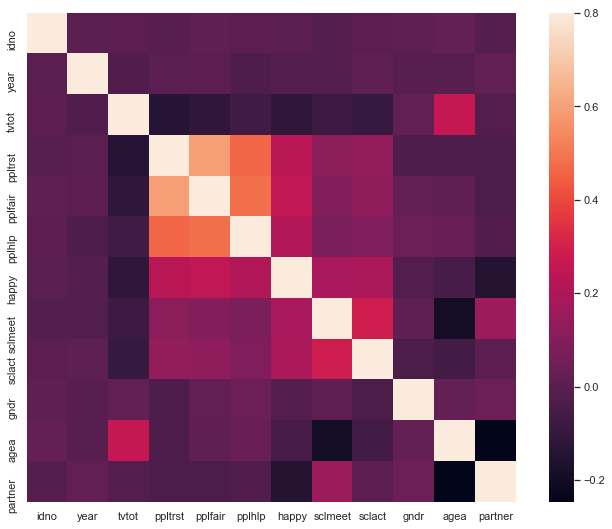

KeyError: 'trust_fair_help'

In [14]:
corrmat = df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Check how well the composite correlates with each of the individual variables.
plotdf = df.loc[:, ['ppltrst', 'pplfair', 'pplhlp']]
plotdf['trust_fair_help'] = features['trust_fair_help'] 
corrmat2 = plotdf.corr()

print(corrmat2)

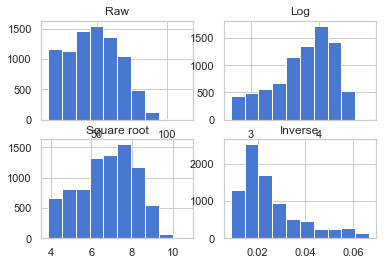

In [15]:

# Making a four-panel plot.
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['agea'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['agea'].dropna()))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['agea'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/df['agea'].dropna())
plt.title('Inverse')
plt.show()

# None of these transformations look particularly great, actually. But let's
# make a feature from the log one.

features['log_age'] = np.log(df['agea'])

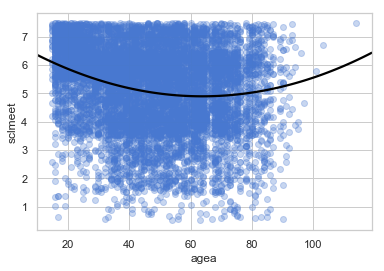

In [16]:
sns.regplot(
    df['agea'],
    y=df['sclmeet'],
    y_jitter=.49,
    order=2,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

features['age_squared'] = df['agea'] * df['agea']

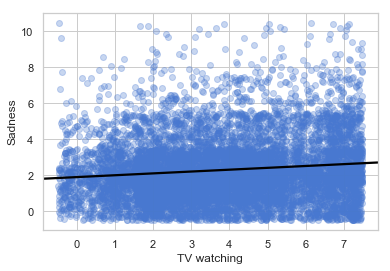

In [17]:
# Reverse-coding the 'happy' variable so that higher scores mean less
# happiness (and thus possibly more sadness).

features['Sadness'] = max(df['happy']) - df['happy']

sns.regplot(
    df['tvtot'],
    features['Sadness'],
    x_jitter=.49,
    y_jitter=.49,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.xlabel('TV watching')
plt.ylabel('Sadness')
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


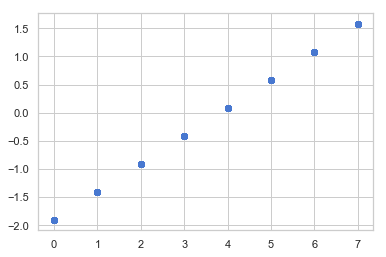

               idno          year         tvtot       ppltrst       pplfair  \
count  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03   
mean  -4.888824e-19 -2.645920e-15 -7.836428e-16 -7.257574e-15 -6.105886e-16   
std    1.000061e+00  1.000061e+00  1.000061e+00  1.000061e+00  1.000061e+00   
min   -6.364414e-02 -1.000614e+00 -1.900914e+00 -2.516209e+00 -2.832624e+00   
25%   -6.196385e-02 -1.000614e+00 -9.053021e-01 -7.108364e-01 -4.741304e-01   
50%   -6.087847e-02  9.993865e-01  9.031023e-02  1.918499e-01 -2.431735e-03   
75%   -5.925039e-02  9.993865e-01  5.881164e-01  6.431931e-01  9.409657e-01   
max    1.734276e+01  9.993865e-01  1.583729e+00  1.997223e+00  1.884363e+00   

             pplhlp         happy       sclmeet        sclact          gndr  \
count  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03   
mean  -8.793070e-17  2.377904e-15 -1.101365e-15 -2.058798e-15 -3.414477e-15   
std    1.000061e+00  1.000061e+00  1.000061e+00  1.

In [18]:

# If this is the first time you're using scikit-learn you'll first want to do
# pip install sklearn from your terminal to install the package.
from sklearn import preprocessing

# Select only numeric variables to scale.
df_num = df.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)

# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['tvtot'], df_scaled['tvtot'])
plt.show()

print(df_scaled.describe())

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


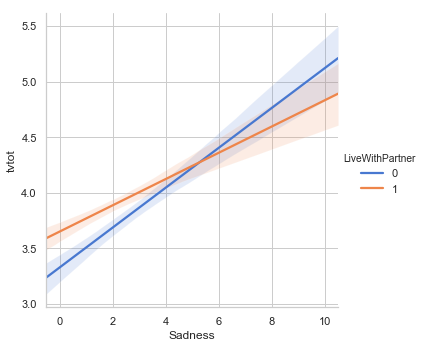

In [19]:
# Create a better indicator for 'partner.' Currently it is coded 1 for
# living with a partner and 2 for not living with a partner.
features['LiveWithPartner'] = np.where(df['partner'] == 1, 1, 0)

# Create the interaction.
features['Sad_Partner'] = features['Sadness'] * features['LiveWithPartner']

# A plot of an interaction.
# Add the 'tvtot' feature to the features data frame for plotting.
features['tvtot'] = df['tvtot']
sns.lmplot(
    x='Sadness',
    y='tvtot',
    hue='LiveWithPartner',
    data=features,
    scatter=False
)
plt.show()

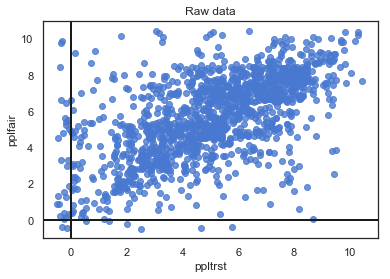

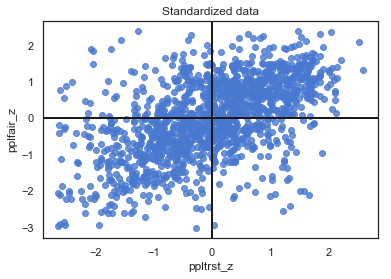

In [20]:
# Setting the default plot aesthetics to be prettier.
sns.set_style("white")

df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv')

# Take a subset of the data for PCA. This limits to Swiss and Czech data from 2012
# and keeps only specific columns.
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year'] == 6),
    ['tvtot','ppltrst','pplfair','pplhlp']
].dropna()

t = sns.regplot(
    'ppltrst',
    'pplfair',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
df_pca['ppltrst_z'] = (df_pca['ppltrst'] - df_pca['ppltrst'].mean()) / df_pca['ppltrst'].std()
df_pca['pplfair_z'] = (df_pca['pplfair'] - df_pca['pplfair'].mean()) / df_pca['pplfair'].std()

t = sns.regplot(
    'ppltrst_z',
    'pplfair_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

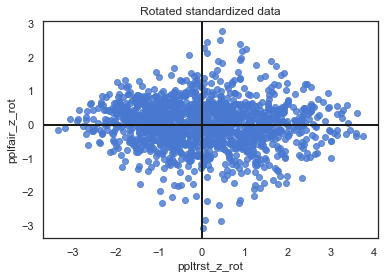

In [21]:
# Rotating the data so that the axes roughly match to vector above.
df_pca['ppltrst_z_rot'] = math.cos(40) * df_pca['ppltrst_z'] - math.sin(40) * df_pca['pplfair_z']
df_pca['pplfair_z_rot'] = math.sin(40) * df_pca['ppltrst_z'] + math.cos(40) * df_pca['pplfair_z']

t = sns.regplot(
    'ppltrst_z_rot',
    'pplfair_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

In [22]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = df.loc[
    ((df['cntry'] == 'CZ') | (df['cntry'] == 'CH')) & (df['year']==6),
    ['tvtot','ppltrst','pplfair','pplhlp']
].dropna()

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(df_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00071174 -0.24535312 -0.23531159 -0.17820482]
 [-0.24535312  1.00071174  0.60528939  0.49609931]
 [-0.23531159  0.60528939  1.00071174  0.53193085]
 [-0.17820482  0.49609931  0.53193085  1.00071174]]


In [23]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 4).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.30084526]
 [ 0.55945823]
 [ 0.5681188 ]
 [ 0.52320135]]
Eigenvalue 1: 2.211256863199824
----------------------------------------
Eigenvector 2: 
[[0.94786152]
 [0.11600843]
 [0.15403897]
 [0.25371751]]
Eigenvalue 2: 0.8847413570711684
----------------------------------------
Eigenvector 3: 
[[ 0.10491426]
 [ 0.51597659]
 [ 0.28505945]
 [-0.80093836]]
Eigenvalue 3: 0.5151421389236892
----------------------------------------
Eigenvector 4: 
[[ 0.00660771]
 [ 0.63821367]
 [-0.75647481]
 [ 0.14277786]]
Eigenvalue 4: 0.39170661589428624
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.55242103 0.22102802 0.12869394 0.097857  ]


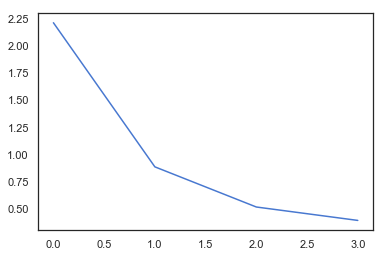

In [24]:
plt.plot(eig_val_cov)
plt.show()

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


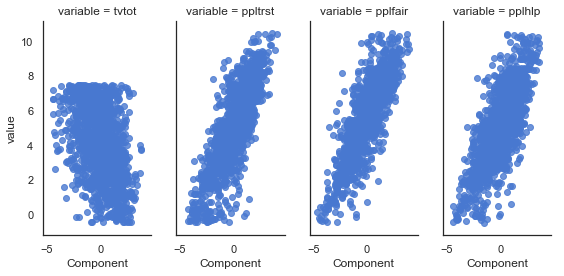

In [25]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = df_pca[['tvtot', 'ppltrst', 'pplfair', 'pplhlp']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()